In [1]:
import sklearn
import pandas as pd
import json

In [2]:
# ------------------------------------------------------------------
# Read the settings json
# ------------------------------------------------------------------
with open('mushroom_features.json','r') as f:
    colmap = json.load(f)

In [3]:
# ------------------------------------------------------------------
# Label the data
# This is pulled from the data description
# ------------------------------------------------------------------
df = pd.read_csv('agaricus-lepiota.data')
columns = ['edibility','cap-shape','cap-surface','cap-color','bruises?','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
df.columns = columns
keepcolumns = [list(i.keys())[0] for i in colmap]
df = df[keepcolumns].copy()

In [4]:
# ------------------------------------------------------------------
# Split into poisonous/non-poisonous
# ------------------------------------------------------------------
tmpmask = df['edibility'] == 'e'
nonpsn  = df.loc[tmpmask].copy()
psn     = df.loc[~tmpmask].copy()
testdf  = df[set(keepcolumns)-set(['edibility'])]


In [5]:
# ------------------------------------------------------------------
# Apply the weights to the 
# ------------------------------------------------------------------
testdf['score'] = 0
for idx in testdf.index:
    # ------------------------------------------------------------------
    # Going through the features from the json
    # ------------------------------------------------------------------
    for fdict in colmap:
        col = list(fdict.keys())[0]
        # ------------------------------------------------------------------
        # If the column has been removed, skip
        # ------------------------------------------------------------------
        if col not in testdf:
            continue
        val  = testdf.loc[idx,col]
        # ------------------------------------------------------------------
        # There are some values that aren't represented in the description
        # ------------------------------------------------------------------
        if val not in fdict[col]:
            print(f'val not found:{val}')
            continue
        # ------------------------------------------------------------------
        # Increment
        # ------------------------------------------------------------------
        testdf.loc[idx,'score'] += fdict[col]['weight'] * fdict[col][val]
testdf

,cap-surface,spore-print-color,veil-color,stalk-surface-above-ring,gill-color,stalk-shape,habitat,stalk-surface-below-ring,cap-color,stalk-color-below-ring,bruises?,veil-type,odor,stalk-color-above-ring,score
0,s,n,w,s,k,e,g,s,y,w,t,p,a,w,28
1,s,n,w,s,n,e,m,s,w,w,t,p,l,w,30
2,y,k,w,s,n,e,u,s,w,w,t,p,p,w,21
3,s,n,w,s,k,t,g,s,g,w,f,p,n,w,32
4,y,k,w,s,n,e,g,s,y,w,t,p,a,w,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,s,b,o,s,y,e,l,s,n,o,f,p,n,o,24
8119,s,b,n,s,y,e,l,s,n,o,f,p,n,o,25
8120,s,b,o,s,n,e,l,s,n,o,f,p,n,o,24
8121,y,w,w,s,b,t,l,k,n,w,f,p,y,w,22


In [6]:
# ------------------------------------------------------------------
# Cut off the sets
# ------------------------------------------------------------------
cutoff = testdf['score'].quantile(.75)
tmpmask = testdf['score'] >= cutoff
top_25 = testdf.loc[tmpmask].copy()
top_25

,cap-surface,spore-print-color,veil-color,stalk-surface-above-ring,gill-color,stalk-shape,habitat,stalk-surface-below-ring,cap-color,stalk-color-below-ring,bruises?,veil-type,odor,stalk-color-above-ring,score
0,s,n,w,s,k,e,g,s,y,w,t,p,a,w,28
1,s,n,w,s,n,e,m,s,w,w,t,p,l,w,30
3,s,n,w,s,k,t,g,s,g,w,f,p,n,w,32
5,s,k,w,s,g,e,m,s,w,w,t,p,a,w,32
6,y,n,w,s,n,e,m,s,w,w,t,p,l,w,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,f,w,w,k,w,e,g,s,w,w,f,p,n,w,39
8098,f,w,w,k,w,e,g,k,w,w,f,p,n,w,38
8100,s,w,w,s,b,t,p,s,e,w,f,p,s,p,28
8108,s,w,w,s,w,e,g,s,w,w,f,p,n,w,40


In [7]:
# ------------------------------------------------------------------
# Cut off the sets
# ------------------------------------------------------------------
testdf['stewability'] = 0
testdf.loc[tmpmask,'stewability'] = 1

In [8]:
from sklearn.preprocessing import OneHotEncoder
# ------------------------------------------------------------------
# Encode the columns
# ------------------------------------------------------------------
x = testdf.drop(['score','stewability'],axis=1)
xcols = x.columns.to_list()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x)
x = enc.transform(x).toarray()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------
# Split the data set
# ------------------------------------------------------------------
y = testdf['stewability'].to_numpy()
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)


In [10]:
# ------------------------------------------------------------------
# Create the model
# ------------------------------------------------------------------
model = RandomForestClassifier(random_state=1)
model.fit(x_train,y_train)
# ------------------------------------------------------------------
# Run the model
# ------------------------------------------------------------------
y_pred = model.predict(x_test)

<AxesSubplot:>

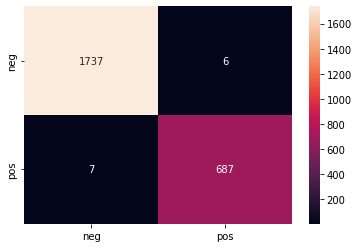

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# ------------------------------------------------------------------
# Confusion matrix
# ------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


In [12]:
finaldf = df.copy()
# ------------------------------------------------------------------
# Run for edible and non-edible
# ------------------------------------------------------------------
finaldf['prediction'] = model.predict(x)
tmpmask = finaldf['edibility'] == 'e'
widowersdf    = finaldf.loc[~tmpmask]
deliciousstew = finaldf.loc[tmpmask]

In [15]:
# ------------------------------------------------------------------
# Histograms of columns
# ------------------------------------------------------------------
df

,edibility,cap-surface,cap-color,bruises?,odor,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,spore-print-color,habitat
0,e,s,y,t,a,k,e,s,s,w,w,p,w,n,g
1,e,s,w,t,l,n,e,s,s,w,w,p,w,n,m
2,p,y,w,t,p,n,e,s,s,w,w,p,w,k,u
3,e,s,g,f,n,k,t,s,s,w,w,p,w,n,g
4,e,y,y,t,a,n,e,s,s,w,w,p,w,k,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,s,n,f,n,y,e,s,s,o,o,p,o,b,l
8119,e,s,n,f,n,y,e,s,s,o,o,p,n,b,l
8120,e,s,n,f,n,n,e,s,s,o,o,p,o,b,l
8121,p,y,n,f,y,b,t,s,k,w,w,p,w,w,l


In [14]:
# ------------------------------------------------------------------
# Random Forest reports (visualization and feature importance)
# ------------------------------------------------------------------

In [19]:
# ------------------------------------------------------------------
# Running this on a random set of mushrooms
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# Create the choice set
# ------------------------------------------------------------------
import random
choicearray = []
for coldict in colmap:
    choicearray.append([i for i in coldict[list(coldict.keys())[0]].keys() if i != 'weight'])
# ------------------------------------------------------------------
# Create the entries
# ------------------------------------------------------------------
entries = []
for i in range(100):
    entries.append([random.choice(i) for i in choicearray])
# ------------------------------------------------------------------
# Run the model against these
# ------------------------------------------------------------------



[['e', 'f', 'w', 'f', 'l', 'n', 'e', 'y', 'k', 'n', 'o', 'u', 'w', 'o', 'd'],
 ['e', 'g', 'r', 't', 'n', 'n', 't', 'f', 'y', 'e', 'w', 'p', 'y', 'n', 'p'],
 ['p', 'y', 'r', 't', 'a', 'b', 't', 'y', 'y', 'w', 'p', 'p', 'y', 'w', 'l'],
 ['p', 's', 'r', 'f', 'y', 'w', 'e', 'f', 's', 'b', 'b', 'p', 'y', 'n', 'u'],
 ['p', 'g', 'p', 't', 'c', 'e', 't', 'y', 'k', 'w', 'c', 'p', 'o', 'y', 'w'],
 ['e', 'y', 'y', 't', 'p', 'p', 'e', 's', 's', 'c', 'p', 'p', 'o', 'o', 'l'],
 ['e', 'g', 'e', 't', 'p', 'p', 'e', 's', 's', 'e', 'p', 'p', 'o', 'y', 'd'],
 ['e', 'y', 'b', 't', 'n', 'g', 'e', 'k', 'f', 'w', 'g', 'p', 'w', 'r', 'g'],
 ['e', 's', 'u', 't', 'm', 'y', 'e', 'f', 'f', 'n', 'g', 'p', 'n', 'o', 'l'],
 ['p', 'y', 'b', 'f', 'c', 'p', 't', 's', 'k', 'e', 'e', 'p', 'n', 'r', 'm'],
 ['e', 'g', 'w', 't', 'y', 'n', 'e', 'k', 'y', 'w', 'b', 'p', 'y', 'w', 'g'],
 ['p', 'f', 'r', 'f', 'a', 'n', 't', 'y', 'y', 'n', 'c', 'u', 'o', 'w', 'd'],
 ['p', 'g', 'b', 't', 'p', 'b', 't', 'k', 'f', 'w', 'p', 'p', 'w

In [ ]:
# ------------------------------------------------------------------
# Write-up (model is the product/exhibition of some "random" mushrooms)
# ------------------------------------------------------------------
